In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from collections import Counter

import os
print(os.listdir("../input"))

%matplotlib inline

['Ratecard.xlsx', 'subscriptionsdataFINAL.csv', 'visitationdataPART1small.csv.xlsx', 'visitationdataPART1.csv', 'visitationdataPART2.csv']


#### Age group Mapping Method
Below method maps age of user to particular group. We'll be creating categorical feature from age attribute.

In [2]:
age_group = {(12,20):'Age_Group_12_20', (21,30):'Age_Group_21_30',(31,40):'Age_Group_31_40', (41,50):'Age_Group_41_50', (51,60):'Age_Group_51_60',
            (61,70):'Age_Group_61_70',}

def age_group_finder(age):
    if age >=12 and age <=20:
        return age_group[(12,20)]
    elif age >=21 and age <=30:
        return age_group[(21,30)]
    elif age >=31 and age <=40:
        return age_group[(31,40)]
    elif age >=41 and age <=50:
        return age_group[(41,50)]
    elif age >=51 and age <=60:
        return age_group[(51,60)]
    elif age >=61 and age <=70:
        return age_group[(61,70)]
    else:
        return 'Senior Citizen'

### Reading Subscriptions Data
Below we are reading subscriptions CSV. We are also deciding on who's still with gym and who has left gym based on subscription End Date. We are also finding out age of each user based on BirthYear and then dividing them into age group based on above function to create categorical feature.

In [3]:
subscriptions = pd.read_csv('../input/subscriptionsdataFINAL.csv', infer_datetime_format=True, parse_dates=True, na_values=
                           '#N/A', index_col=['CustomerID'])
subscriptions['Left_Gym'] = [(0 if str(date) == 'nan' else 1) for date in subscriptions['End Date']]
subscriptions['End Date'] = [('Aug-19' if str(date) == 'nan' else date) for date in subscriptions['End Date']]
subscriptions['Age'] = [(2019-year) for year in subscriptions.BirthYear]
subscriptions['AgeGroup'] = [age_group_finder(age) for age in subscriptions.Age]
print('Subscriptions Dataset Size : ',subscriptions.shape)
subscriptions.head()

Subscriptions Dataset Size :  (850033, 10)


,Club,Join Date,Affluence,Gender,Subscription Type,End Date,BirthYear,Left_Gym,Age,AgeGroup
CustomerID,,,,,,,,,,
1,Enfield,Dec-11,C1,Male,Standard,Dec-11,1992,1,27,Age_Group_21_30
2,Greenwich,Jun-18,A,Female,Standard,Aug-19,1972,0,47,Age_Group_41_50
3,Islington,Mar-18,B,Female,Standard,Oct-18,1985,1,34,Age_Group_31_40
4,Hounslow,Oct-15,C1,Female,Standard,Dec-15,1972,1,47,Age_Group_41_50
5,Barnet,May-15,C2,Male,Standard,Dec-15,1982,1,37,Age_Group_31_40


In [4]:
subscriptions.dtypes

Club                 object
Join Date            object
Affluence            object
Gender               object
Subscription Type    object
End Date             object
BirthYear             int64
Left_Gym              int64
Age                   int64
AgeGroup             object
dtype: object

### Cleaning Date Data
When we read data it did not parse date data for `Join Data` and `End Date` properly hence we are below converting them to proper date format. We are also introducing new attribute called `Membership Days` which will hold number of days user have been member of Gym.

In [5]:
months = {'Jan':1, 'Feb':2, 'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}
years = {'09':2009, '10':2010, '11':2011,'12':2012, '13':2013, '14':2014, '15':2015, '16':2016, '17':2017, '18':2018, '19':2019}
join_date = []

for dt in subscriptions['Join Date']:
    month, year = dt.split('-')
    join_date.append(datetime.date(years[year],months[month],1))
end_date = []
for dt in subscriptions['End Date']:
    month, year = dt.split('-')
    end_date.append(datetime.date(years[year],months[month],1))
diff = [(end-start).days for start, end in zip(join_date, end_date)]

subscriptions['Join Date'] = join_date
subscriptions['End Date'] = end_date
subscriptions['Membership Days'] = diff

#### Membership Duration Group Creation Function
Below function takes number of days user has been member to gym and then divide it into groups like `LessThan6Months, Between6MonthsTo1Year, Between1To2Years` etc.

In [6]:
def membership_duration(days):
    if days < 183:
        return 'LessThan6Months'
    elif days >=183 and days <=365:
        return 'Between6MonthsTo1Year'
    elif days >=366 and days <= (365*2):
        return 'Between1To2Years'
    elif days >=((365*2)+1) and days <= (365*3):
        return 'Between2To3Years'
    elif days >=((365*3)+1) and days <= (365*4):
        return 'Between3To4Years'
    elif days >=((365*4)+1) and days <= (365*5):
        return 'Between4To5Years'
    else:
        return 'GreaterThan5Years'

### Creating MembershipDuration groups attribute
Below we are creating new attribute called `MembershipDuration` which will assign group to each user using above function based on number of days user have been member to gym.

In [7]:
subscriptions['MembershipDuration'] = [membership_duration(days) for days in subscriptions['Membership Days']]

In [8]:
subscriptions.head()

,Club,Join Date,Affluence,Gender,Subscription Type,End Date,BirthYear,Left_Gym,Age,AgeGroup,Membership Days,MembershipDuration
CustomerID,,,,,,,,,,,,
1,Enfield,2011-12-01,C1,Male,Standard,2011-12-01,1992,1,27,Age_Group_21_30,0,LessThan6Months
2,Greenwich,2018-06-01,A,Female,Standard,2019-08-01,1972,0,47,Age_Group_41_50,426,Between1To2Years
3,Islington,2018-03-01,B,Female,Standard,2018-10-01,1985,1,34,Age_Group_31_40,214,Between6MonthsTo1Year
4,Hounslow,2015-10-01,C1,Female,Standard,2015-12-01,1972,1,47,Age_Group_41_50,61,LessThan6Months
5,Barnet,2015-05-01,C2,Male,Standard,2015-12-01,1982,1,37,Age_Group_31_40,214,Between6MonthsTo1Year


In [9]:
subscriptions.dtypes

Club                  object
Join Date             object
Affluence             object
Gender                object
Subscription Type     object
End Date              object
BirthYear              int64
Left_Gym               int64
Age                    int64
AgeGroup              object
Membership Days        int64
MembershipDuration    object
dtype: object

### Loading Visitation Data
Below we are loading both visitation data.

In [10]:
%%time

visitation_data_part1 = pd.read_csv('../input/visitationdataPART1.csv', parse_dates=['visitdate'])
visitation_data_part2 = pd.read_csv('../input/visitationdataPART2.csv', parse_dates=['visitdate'])

CPU times: user 59.8 s, sys: 6.3 s, total: 1min 6s
Wall time: 1min 5s


#### Gym Visit Time method
Below method takes users visiting time as input and returns when user visits gym.

In [11]:
def gym_visit_time(tm):
    if tm >= datetime.time(4,0) and tm <= datetime.time(11,59):
        return 'Morning'
    elif tm >= datetime.time(12,1) and tm <= datetime.time(17,0):
        return 'AfterNoon'
    elif tm >= datetime.time(17,1) and tm <= datetime.time(20,0):
        return 'Evening'
    elif tm >= datetime.time(20,1) and tm <= datetime.time(23,59):
        return 'Night'
    else:
        return 'LateNight'

### Visitation Data Cleaning and Attribute Creation
Below we are first combining visitation data from 2 csv files. We are then converting `TimeofVisit` attribute to `datetime.time` format.

Using `TimeofVisit` attribute we find out when particular person visits Gym.

In [12]:
%%time

visitation_data = pd.concat((visitation_data_part1,visitation_data_part2))
visitation_data = visitation_data.set_index('CustomerID')
visitation_data['TimeofVisit'] = [datetime.time(int(dt.split(':')[0]),int(dt.split(':')[1])) for dt in visitation_data['TimeofVisit']]
visitation_data['VisitGroup'] = [gym_visit_time(tm) for tm in visitation_data['TimeofVisit']]
visitation_data = pd.get_dummies(visitation_data, columns=['VisitGroup'])
print('Visitation Dataset Size : ',visitation_data.shape)
del visitation_data_part1, visitation_data_part2

Visitation Dataset Size :  (69514576, 8)
CPU times: user 3min 26s, sys: 18.1 s, total: 3min 44s
Wall time: 3min 41s


In [13]:
#print('Visitation Dataset Size : ',visitation_data.shape)
visitation_data.head(10)

,visitdate,TimeofVisit,peakvisits,VisitGroup_AfterNoon,VisitGroup_Evening,VisitGroup_LateNight,VisitGroup_Morning,VisitGroup_Night
CustomerID,,,,,,,,
126444,2009-05-01,05:45:00,False,0,0,0,1,0
456610,2009-05-01,05:45:00,False,0,0,0,1,0
293763,2009-05-01,06:00:00,False,0,0,0,1,0
151253,2009-05-01,06:15:00,False,0,0,0,1,0
476569,2009-05-01,06:15:00,False,0,0,0,1,0
360862,2009-05-01,06:15:00,False,0,0,0,1,0
562,2009-05-01,06:45:00,False,0,0,0,1,0
528681,2009-05-01,06:45:00,False,0,0,0,1,0
639387,2009-05-01,06:45:00,False,0,0,0,1,0


In [14]:
visitation_data.dtypes

visitdate               datetime64[ns]
TimeofVisit                     object
peakvisits                        bool
VisitGroup_AfterNoon             uint8
VisitGroup_Evening               uint8
VisitGroup_LateNight             uint8
VisitGroup_Morning               uint8
VisitGroup_Night                 uint8
dtype: object

### User Visitation Time to Gym Visualisation

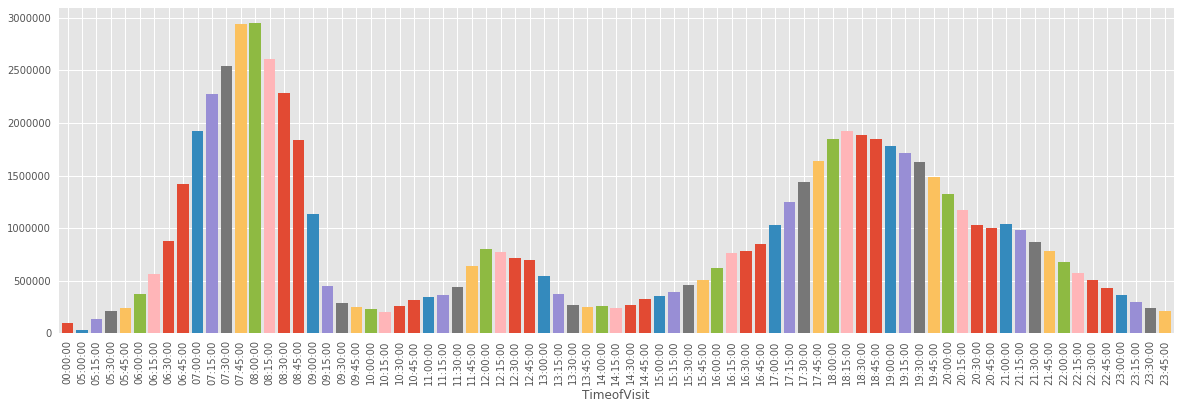

In [15]:
with plt.style.context(('seaborn', 'ggplot')):
    visitation_data.groupby('TimeofVisit').count()['peakvisits'].plot(kind='bar',figsize=(20,6), width=0.80);

### Creating Visit Time Groups Dataframe
Below we are creating new dataframe from visitation data. It finds out how many times user visited Gym during particular VisitGroup(like Monring,Evening etc). Based on that it decides each users visiting group based on maximum number of entry for particular group. If user has visited gym mostly in Morning then he's morning person.

In [16]:
%%time

grp_map = dict(zip(range(0,5), ['AfterNoon','Evening','LateNight','Morning','Night']))
visit_group_data = visitation_data.groupby(by='CustomerID').sum()[['VisitGroup_AfterNoon','VisitGroup_Evening','VisitGroup_LateNight','VisitGroup_Morning','VisitGroup_Night']]
visit_group_data['VisitGroup'] = [grp_map[grp] for grp in visit_group_data.values.argmax(axis=1)]
visit_group_data.head()

CPU times: user 17.6 s, sys: 5.02 s, total: 22.7 s
Wall time: 22.3 s


,VisitGroup_AfterNoon,VisitGroup_Evening,VisitGroup_LateNight,VisitGroup_Morning,VisitGroup_Night,VisitGroup
CustomerID,,,,,,
1,5.0,6.0,0.0,5.0,4.0,Evening
2,9.0,24.0,1.0,29.0,11.0,Morning
3,21.0,66.0,1.0,63.0,14.0,Evening
4,8.0,15.0,3.0,20.0,6.0,Morning
5,11.0,39.0,3.0,31.0,9.0,Evening


In [17]:
visitation_data.head(20)

,visitdate,TimeofVisit,peakvisits,VisitGroup_AfterNoon,VisitGroup_Evening,VisitGroup_LateNight,VisitGroup_Morning,VisitGroup_Night
CustomerID,,,,,,,,
126444,2009-05-01,05:45:00,False,0,0,0,1,0
456610,2009-05-01,05:45:00,False,0,0,0,1,0
293763,2009-05-01,06:00:00,False,0,0,0,1,0
151253,2009-05-01,06:15:00,False,0,0,0,1,0
476569,2009-05-01,06:15:00,False,0,0,0,1,0
360862,2009-05-01,06:15:00,False,0,0,0,1,0
562,2009-05-01,06:45:00,False,0,0,0,1,0
528681,2009-05-01,06:45:00,False,0,0,0,1,0
639387,2009-05-01,06:45:00,False,0,0,0,1,0


### Merging Subscriptions Dataset with Visitation Data
Below we are first merging subscriptions data with `TimeofVisit` data of visitation dataset. We are then adding `peakvisits` and `VisitGroup` attributes from visitation dataset. We also find out `VisitRate` for each user based on number of days he visited gym divided by number of days he/she has visited gym. We then decide user `VisitFrequency` based on `VisitRate`.

In [18]:
%%time

subscriptions = subscriptions.join(visitation_data.groupby(by='CustomerID').count()['TimeofVisit'])
subscriptions = subscriptions.join(visitation_data.groupby(by='CustomerID').sum()['peakvisits'])
subscriptions = subscriptions.join(visit_group_data['VisitGroup'])
subscriptions = subscriptions.rename(columns = {'TimeofVisit': 'NoOfVisits'})
subscriptions['VisitRate'] = subscriptions['NoOfVisits'] / (subscriptions['Membership Days']+1)
subscriptions['VisitRate'] = [(0.0 if rate >1.0 and rate < 0.0 else rate) for rate in subscriptions['VisitRate']]
subscriptions['VisitFrequency'] = [('VeryRegular' if rate > 0.80 else 'Regular' if rate > 0.5 and rate <=0.80 else 'NotRegular' if rate > 0.3 and rate <=0.50  else 'Irregular') for rate in subscriptions['VisitRate']]
subscriptions.head()

CPU times: user 39 s, sys: 7.36 s, total: 46.4 s
Wall time: 45.3 s


,Club,Join Date,Affluence,Gender,Subscription Type,End Date,BirthYear,Left_Gym,Age,AgeGroup,Membership Days,MembershipDuration,NoOfVisits,peakvisits,VisitGroup,VisitRate,VisitFrequency
CustomerID,,,,,,,,,,,,,,,,,
1,Enfield,2011-12-01,C1,Male,Standard,2011-12-01,1992,1,27,Age_Group_21_30,0,LessThan6Months,20.0,9.0,Evening,20.000000,VeryRegular
2,Greenwich,2018-06-01,A,Female,Standard,2019-08-01,1972,0,47,Age_Group_41_50,426,Between1To2Years,74.0,41.0,Morning,0.173302,Irregular
3,Islington,2018-03-01,B,Female,Standard,2018-10-01,1985,1,34,Age_Group_31_40,214,Between6MonthsTo1Year,165.0,110.0,Evening,0.767442,Regular
4,Hounslow,2015-10-01,C1,Female,Standard,2015-12-01,1972,1,47,Age_Group_41_50,61,LessThan6Months,52.0,32.0,Morning,0.838710,VeryRegular
5,Barnet,2015-05-01,C2,Male,Standard,2015-12-01,1982,1,37,Age_Group_31_40,214,Between6MonthsTo1Year,93.0,63.0,Evening,0.432558,NotRegular


### Backfilling Missing Data

In [19]:
subscriptions = subscriptions.fillna(method='backfill')

### Visualising VisitFrequency

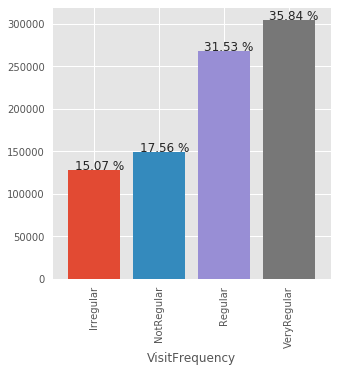

In [20]:
with plt.style.context(('seaborn', 'ggplot')):
    freq = Counter(subscriptions.VisitFrequency)
    subscriptions.groupby('VisitFrequency').count()['NoOfVisits'].sort_values().plot(kind='bar', figsize=(5,5), width=0.80)
    for i, (key, val) in enumerate(sorted(freq.items(),key=lambda x: x[1])):
        plt.text(i-0.3,freq[key]+100, '%.2f'%(freq[key]*100/subscriptions.shape[0])+ ' %', fontsize=12)

### Visualising VisitGroup

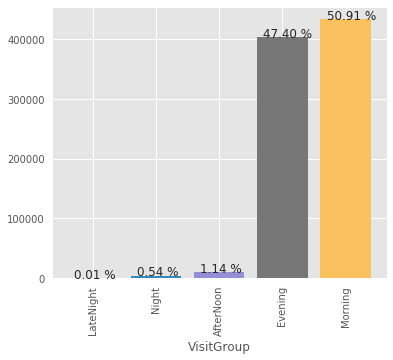

In [21]:
with plt.style.context(('seaborn', 'ggplot')):
    freq = Counter(subscriptions.VisitGroup)
    #print(freq)
    subscriptions.groupby('VisitGroup').count()['NoOfVisits'].sort_values().plot(kind='bar', figsize=(6,5), width=0.80)
    for i, (key, val) in enumerate(sorted(freq.items(),key=lambda x: x[1])):
        plt.text(i-0.3,freq[key]+100, '%.2f'%(freq[key]*100/subscriptions.shape[0])+ ' %', fontsize=12)

### Visualising MembershipDuration

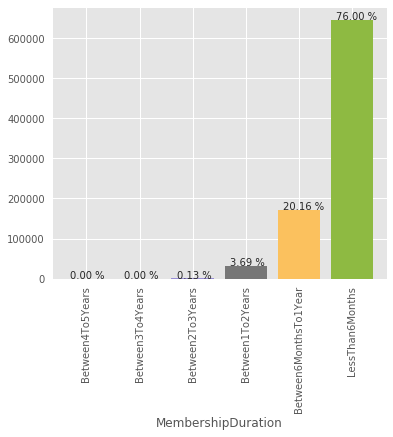

In [22]:
with plt.style.context(('seaborn', 'ggplot')):
    freq = Counter(subscriptions.MembershipDuration)
    subscriptions.groupby('MembershipDuration').count()['NoOfVisits'].sort_values().plot(kind='bar', figsize=(6,5), width=0.80)
    for i, (key, val) in enumerate(sorted(freq.items(),key=lambda x: x[1])):
        plt.text(i-0.3,freq[key]+100, '%.2f'%(freq[key]*100/subscriptions.shape[0])+ ' %', fontsize=10)

### Visualising AgeGroup

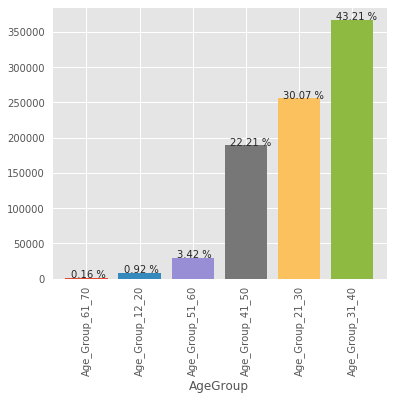

In [23]:
with plt.style.context(('seaborn', 'ggplot')):
    freq = Counter(subscriptions.AgeGroup)
    subscriptions.groupby('AgeGroup').count()['NoOfVisits'].sort_values().plot(kind='bar', figsize=(6,5), width=0.80);
    for i, (key, val) in enumerate(sorted(freq.items(),key=lambda x: x[1])):
        plt.text(i-0.3,freq[key]+5, '%.2f'%(freq[key]*100/subscriptions.shape[0])+ ' %', fontsize=10)

In [24]:
#with plt.style.context(('seaborn', 'ggplot')):
#    subscriptions.groupby('Age').count()['NoOfVisits'].plot(kind='bar', figsize=(20,6), width=0.80);

### Visualising Gender Distribution

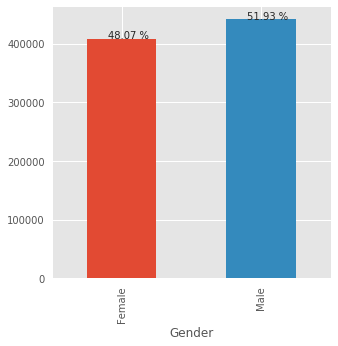

In [25]:
with plt.style.context(('seaborn', 'ggplot')):
    freq = Counter(subscriptions.Gender)
    subscriptions.groupby('Gender').count()['NoOfVisits'].sort_values().plot(kind='bar', figsize=(5,5));
    for i, (key, val) in enumerate(sorted(freq.items(),key=lambda x: x[1])):
        plt.text(i-0.1,freq[key]+100, '%.2f'%(freq[key]*100/subscriptions.shape[0])+ ' %', fontsize=10)

### Visualising Subscription Type

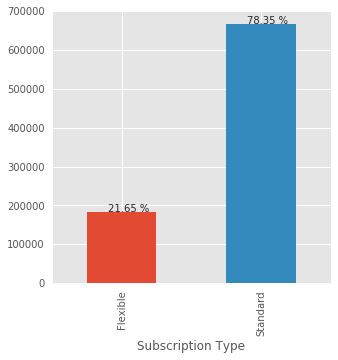

In [26]:
with plt.style.context(('seaborn', 'ggplot')):
    freq = Counter(subscriptions['Subscription Type'])
    subscriptions.groupby('Subscription Type').count()['NoOfVisits'].plot(kind='bar', figsize=(5,5));
    for i, (key, val) in enumerate(sorted(freq.items(),key=lambda x: x[1])):
        plt.text(i-0.1,freq[key]+100, '%.2f'%(freq[key]*100/subscriptions.shape[0])+ ' %', fontsize=10)

### Visualising Affluence

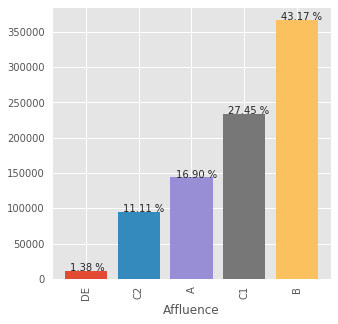

In [27]:
with plt.style.context(('seaborn', 'ggplot')):
    freq = Counter(subscriptions['Affluence'])
    subscriptions.groupby('Affluence').count()['NoOfVisits'].sort_values().plot(kind='bar', figsize=(5,5), width=0.80);
    for i, (key, val) in enumerate(sorted(freq.items(),key=lambda x: x[1])):
        plt.text(i-0.3,freq[key]+100, '%.2f'%(freq[key]*100/subscriptions.shape[0])+ ' %', fontsize=10)

### Visualising Club

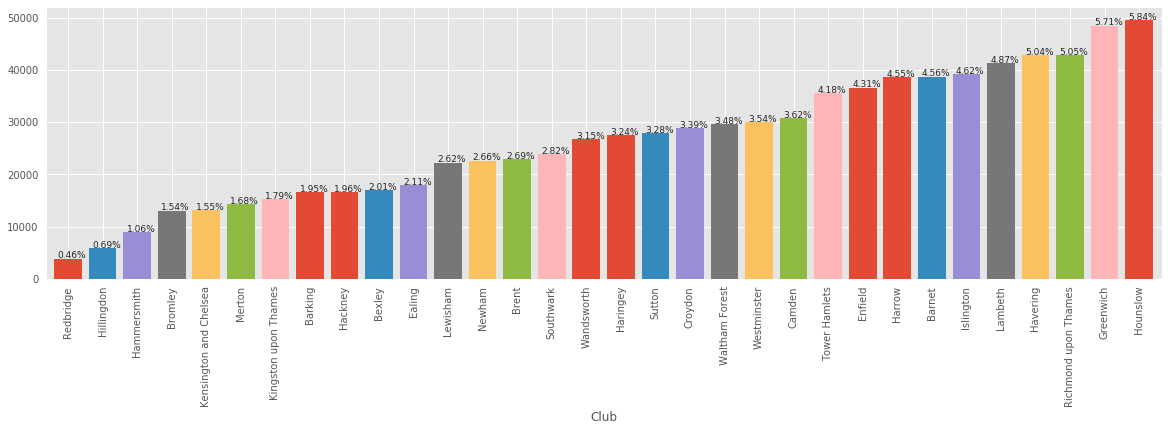

In [28]:
with plt.style.context(('seaborn', 'ggplot')):
    freq = Counter(subscriptions['Club'])
    subscriptions.groupby('Club').count()['NoOfVisits'].sort_values().plot(kind='bar', figsize=(20,5), width=0.80);
    for i, (key, val) in enumerate(sorted(freq.items(),key=lambda x: x[1])):
        plt.text(i-0.3,freq[key]+100, '%.2f'%(freq[key]*100/subscriptions.shape[0])+ '%', fontsize=9)

### Visualising User's Has Left Gym/Still Member Distribution

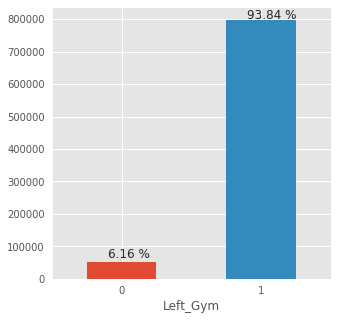

In [29]:
with plt.style.context(('seaborn', 'ggplot')):
    left_count = Counter(subscriptions.Left_Gym)
    subscriptions.groupby('Left_Gym').count()['NoOfVisits'].plot(kind='bar', figsize=(5,5))
    plt.xticks(rotation='horizontal')
    plt.text(0-0.1,65000, '%.2f'%(left_count[0]*100/subscriptions.shape[0])+ ' %', fontsize=12)
    plt.text(1-0.1,800000, '%.2f'%(left_count[1]*100/subscriptions.shape[0])+ ' %',fontsize=12);

### Creating Features, Target Variables Arrays for ML Model

In [30]:
final_X_df = pd.get_dummies(subscriptions[['Club','Affluence','Gender','Subscription Type','Age','Membership Days','NoOfVisits', 'peakvisits', 'VisitGroup','AgeGroup','MembershipDuration','VisitRate','VisitFrequency']],
                   columns=['Club','Affluence','Gender','Subscription Type', 'VisitGroup', 'AgeGroup','MembershipDuration','VisitFrequency'])
X, Y = final_X_df.values, subscriptions['Left_Gym'].values
print('Dataset Shapes : ',X.shape, Y.shape)

Dataset Shapes :  (850033, 67) (850033,)


### Split Data Into Train/Test Sets

In [31]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix, classification_report

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.70, test_size=0.30, stratify=Y, random_state=123)
print('Train/Test Shapes : ',X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

Train/Test Shapes :  (595023, 67) (255010, 67) (595023,) (255010,)


### Scaling Data, Initializing Model And Training Model

In [32]:
%%time

rs = RobustScaler()
X_train = rs.fit_transform(X_train)
X_test = rs.transform(X_test)

lr = LogisticRegression(solver='lbfgs', max_iter=500)
lr.fit(X_train, Y_train)

CPU times: user 1min 18s, sys: 580 ms, total: 1min 19s
Wall time: 48.4 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [33]:
Y_preds = lr.predict(X_test)

print('Test Accuracy : %.2f'%lr.score(X_test, Y_test))
print('Train Accuracy : %.2f'%lr.score(X_train, Y_train))
print('Test Classficiation Report : ')
print(classification_report(Y_test, Y_preds))

Test Accuracy : 0.99
Train Accuracy : 0.99
Test Classficiation Report : 
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     15713
           1       0.99      0.99      0.99    239297

    accuracy                           0.99    255010
   macro avg       0.94      0.95      0.95    255010
weighted avg       0.99      0.99      0.99    255010



### Visualising Confusion Matrix

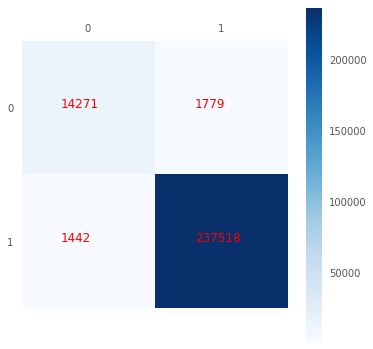

In [34]:
conf_mat = confusion_matrix(Y_test, Y_preds)

with plt.style.context(('seaborn', 'ggplot')):
    fig = plt.figure(figsize=(6,6))
    plt.matshow(conf_mat, cmap = plt.cm.Blues, fignum=1)
    plt.colorbar()
    plt.grid(None)
    for i in range(2):
        for j in range(2):
            plt.text(i-0.2,j, str(conf_mat[i,j]), fontsize=12, color='red');

### Creating DataFrame Based On ML Model's Coefficients

In [35]:
coef_df = pd.DataFrame({'Features':final_X_df.columns, 'Coefficient Values': lr.coef_[0]})
coef_positives = coef_df[coef_df['Coefficient Values'] > 0.0].sort_values('Coefficient Values')
coef_negatives = coef_df[coef_df['Coefficient Values'] < 0.0].sort_values('Coefficient Values', ascending=False)

### Positive Coefficients Affecting Positive Class 1 (Person Leaving Gym - High Churn Rate)

In [36]:
coef_positives

,Features,Coefficient Values
63,VisitFrequency_Irregular,0.007852
43,Gender_Male,0.068223
37,Affluence_A,0.108602
47,VisitGroup_Evening,0.175667
32,Club_Sutton,0.220949
31,Club_Southwark,0.277929
49,VisitGroup_Morning,0.285709
44,Subscription Type_Flexible,0.292730
60,MembershipDuration_Between4To5Years,0.315806
11,Club_Croydon,0.328486


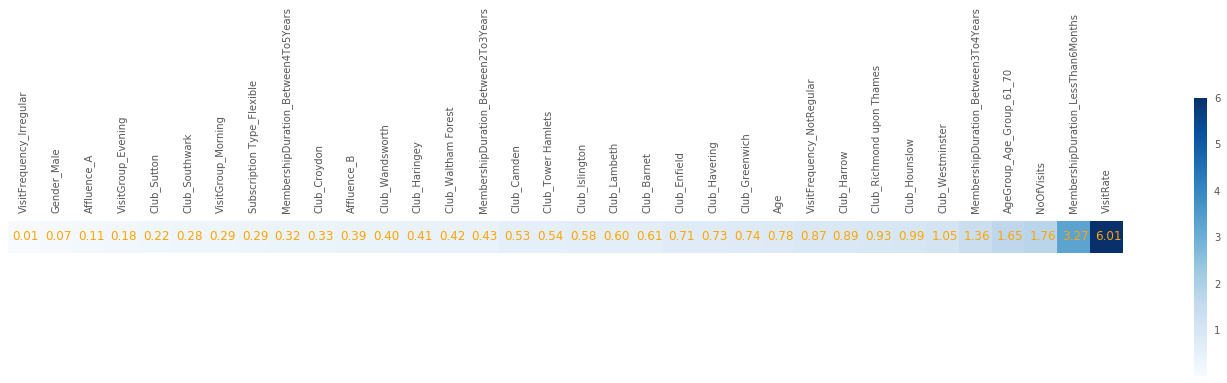

In [37]:
with plt.style.context(('seaborn', 'ggplot')):
    fig = plt.figure(figsize=(25,5))
    plt.matshow(coef_positives['Coefficient Values'].values.reshape(1,-1), fignum=1, cmap = plt.cm.Blues)
    plt.xticks(range(len(coef_positives)), coef_positives.Features, rotation='vertical')
    plt.yticks([])
    plt.grid(None)
    plt.colorbar()
    for i in range(len(coef_positives)):
        plt.text(i-0.35,0.1, '%.2f'%coef_positives['Coefficient Values'].values[i], color='orange', fontsize=12)

### Negative Coefficients Affecting Negative Class 0(Person Continuing Gym - Low Churn Rate)

In [38]:
coef_negatives

,Features,Coefficient Values
65,VisitFrequency_Regular,-0.002855
39,Affluence_C1,-0.015306
54,AgeGroup_Age_Group_41_50,-0.019660
48,VisitGroup_LateNight,-0.020946
28,Club_Newham,-0.066460
42,Gender_Female,-0.068223
12,Club_Ealing,-0.100495
40,Affluence_C2,-0.175677
52,AgeGroup_Age_Group_21_30,-0.189078
46,VisitGroup_AfterNoon,-0.197016


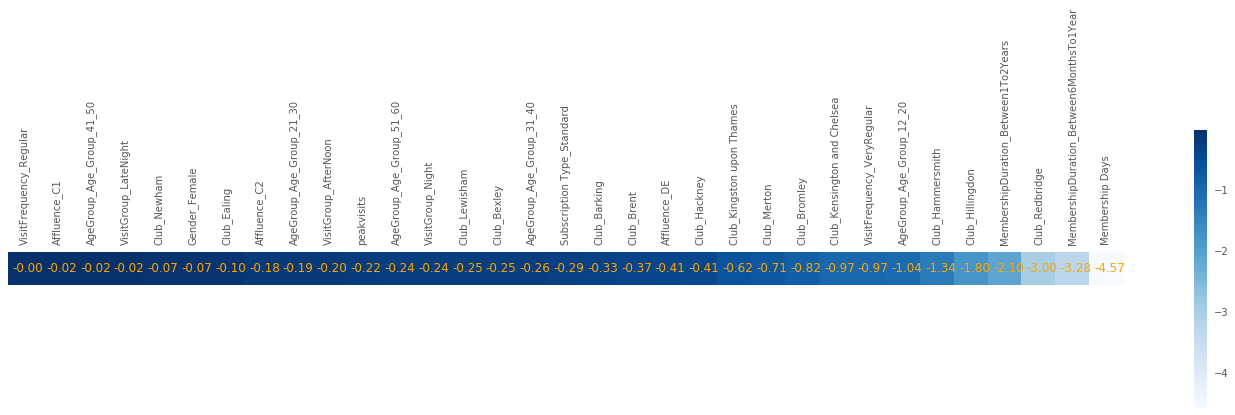

In [39]:
with plt.style.context(('seaborn', 'ggplot')):
    fig = plt.figure(figsize=(25,5))
    plt.matshow(coef_negatives['Coefficient Values'].values.reshape(1,-1), fignum=1, cmap = plt.cm.Blues)
    plt.xticks(range(len(coef_negatives)), coef_negatives.Features, rotation='vertical')
    plt.yticks([])
    plt.grid(None)
    plt.colorbar()
    for i in range(len(coef_negatives)):
        plt.text(i-0.35,0.1, '%.2f'%coef_negatives['Coefficient Values'].values[i], color='orange', fontsize=12)

### Feature Correlation with Gym Leaving Decision

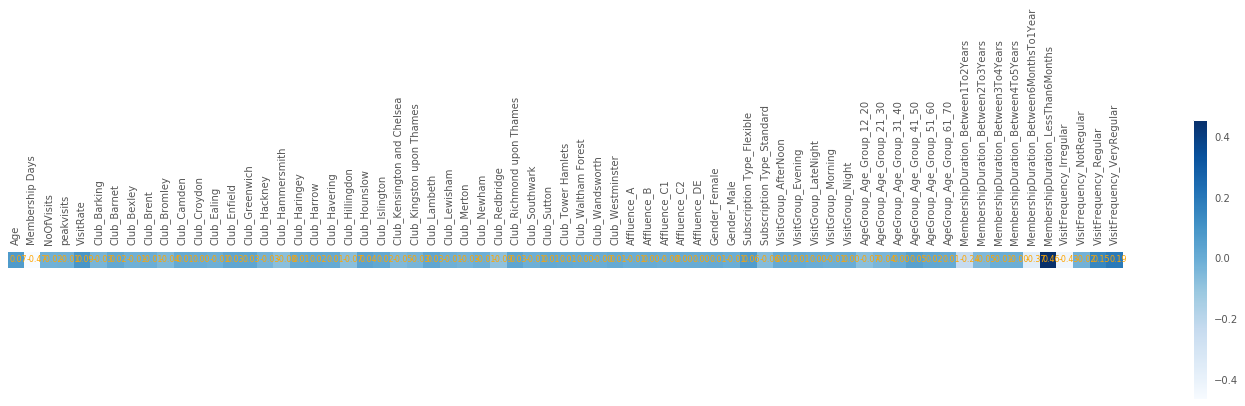

In [40]:
with plt.style.context(('seaborn', 'ggplot')):
    fig = plt.figure(figsize=(25,5))
    corr_values = final_X_df.corrwith(subscriptions['Left_Gym']).values
    plt.matshow(corr_values.reshape(1,-1),fignum=1, cmap = plt.cm.Blues)
    plt.grid(None)
    for i in range(len(final_X_df.columns)):
        plt.text(i-0.35,0.1, '%.2f'%corr_values[i], color='orange', fontsize=8)
    plt.xticks(range(len(final_X_df.columns)), final_X_df.columns, rotation='vertical')
    plt.yticks([])
    plt.colorbar();

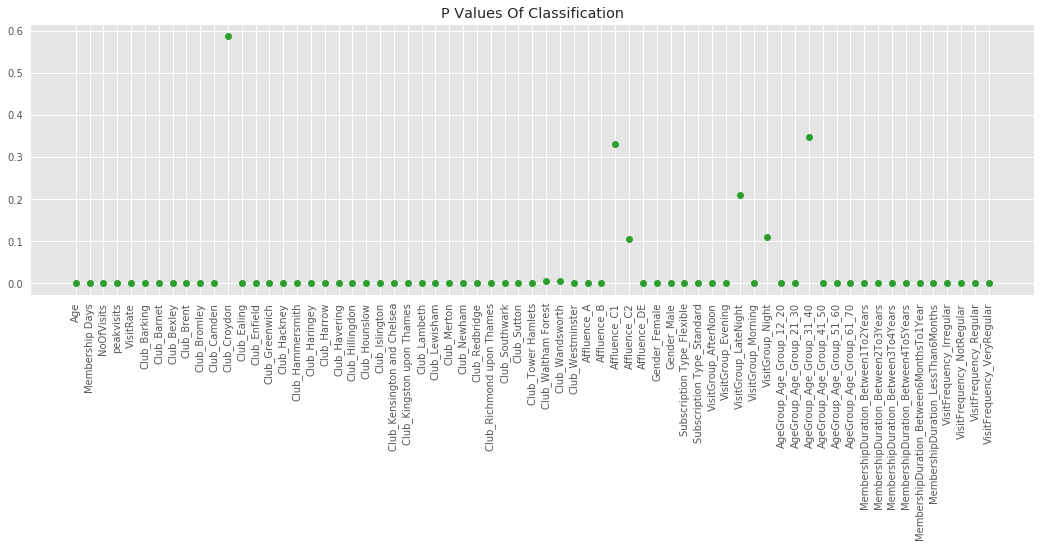

In [41]:
from sklearn.feature_selection import f_regression, f_classif, chi2

F_classif, p_value_classif = f_classif(X, Y)

with plt.style.context(('seaborn', 'ggplot')):
    plt.figure(figsize=(18,5))
    #plt.subplot(121)
    plt.plot(p_value_classif, 'o', c = 'tab:green')
    plt.title('P Values Of Classification')
    plt.xticks(range(len(final_X_df.columns)), final_X_df.columns, rotation='vertical')
    #plt.subplot(122)
    #plt.plot(F_classif, 'o', c = 'tab:red')
    #plt.title('F Values Of Classification');

In [42]:
#pd.read_excel('../input/Ratecard.xlsx', skiprows=1)